# Practical Lab 3

## Done by ***Eris Leksi***

HELLO!

In this notebook, we fine-tune a pre-trained VGG16 model and compare its performance with a custom-built Convolutional Neural Network (CNN) on the Dogs vs Cats classification task. We'll work with a reduced dataset (5,000 images), perform exploratory data analysis (EDA), train both models, evaluate their performance using a range of metrics, and analyze cases where the models fail to predict accurately. This approach demonstrates how to adapt existing deep learning models to specific tasks through transfer learning.

LET'S START!

Dataset: Dogs vs Cats

Source: Kaggle

Link to Dataset: https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats

## 0. Importing the libraries

In [ ]:
import os
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
import shutil
import pathlib
import glob
import pandas as pd
from PIL import Image
from PIL import UnidentifiedImageError
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score
from tensorflow.keras.preprocessing import image

## 1. Getting the data

In [10]:
SOURCE_DIR = "data/train/train"

OUTPUT_DIR = "data/sample_5000"
CAT_DIR = os.path.join(OUTPUT_DIR, "cats")
DOG_DIR = os.path.join(OUTPUT_DIR, "dogs")

os.makedirs(CAT_DIR, exist_ok=True)
os.makedirs(DOG_DIR, exist_ok=True)

all_files = os.listdir(SOURCE_DIR)
cat_files = [f for f in all_files if f.startswith("cat.")]
dog_files = [f for f in all_files if f.startswith("dog.")]

random.shuffle(cat_files)
random.shuffle(dog_files)

cat_subset = cat_files[:2500]
dog_subset = dog_files[:2500]

for f in cat_subset:
    shutil.copy(os.path.join(SOURCE_DIR, f), os.path.join(CAT_DIR, f))

for f in dog_subset:
    shutil.copy(os.path.join(SOURCE_DIR, f), os.path.join(DOG_DIR, f))

print("Copied 2,500 cat and 2,500 dog images to data/sample_5000/")


Copied 2,500 cat and 2,500 dog images to data/sample_5000/


## 2. Showing some EDA about the dataset

### 2.1. Basic EDA about the dataset

Number of cat images: 2500
Number of dog images: 2500
Total images: 5000

Sample image shapes:
Cat image shape: (499, 489, 3)
Dog image shape: (375, 499, 3)


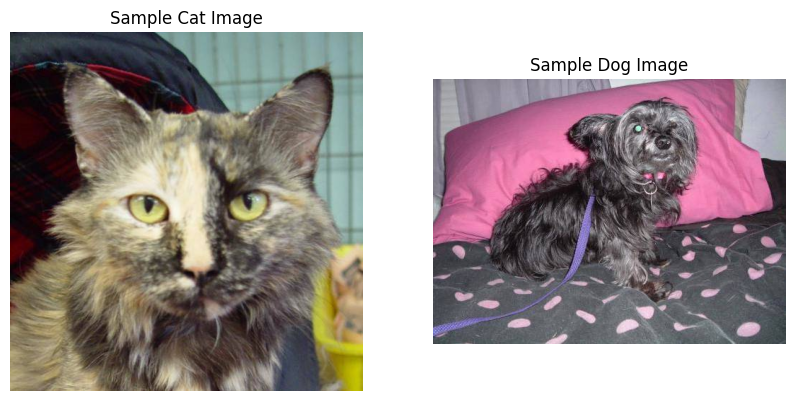

In [11]:
# Count total images in each category
cat_images = len(os.listdir(CAT_DIR))
dog_images = len(os.listdir(DOG_DIR))

print(f"Number of cat images: {cat_images}")
print(f"Number of dog images: {dog_images}")
print(f"Total images: {cat_images + dog_images}")

# Display sample image dimensions
sample_cat = plt.imread(os.path.join(CAT_DIR, os.listdir(CAT_DIR)[0]))
sample_dog = plt.imread(os.path.join(DOG_DIR, os.listdir(DOG_DIR)[0]))

print("\nSample image shapes:")
print(f"Cat image shape: {sample_cat.shape}")
print(f"Dog image shape: {sample_dog.shape}")

# Plot sample images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(sample_cat)
ax1.set_title('Sample Cat Image')
ax1.axis('off')
ax2.imshow(sample_dog)
ax2.set_title('Sample Dog Image')
ax2.axis('off')
plt.show()

Here, we count the total number of images in each category (cats and dogs) and display the dimensions of a sample image from each. Finally, we visualize one example from both categories to get a quick sense of the data.

### 2.2. Image distribution

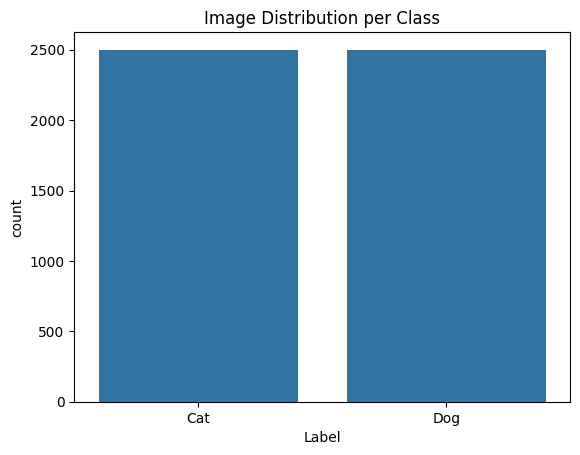

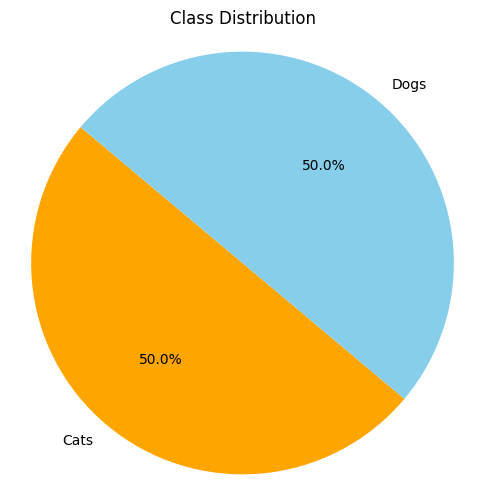

In [19]:
labels = ['Cat'] * cat_images + ['Dog'] * dog_images
df = pd.DataFrame({'Label': labels})

sns.countplot(x='Label', data=df)
plt.title("Image Distribution per Class")
plt.show()

plt.figure(figsize=(6, 6))
plt.pie([cat_images, dog_images], labels=["Cats", "Dogs"], autopct='%1.1f%%', startangle=140, colors=["orange", "skyblue"])
plt.title("Class Distribution")
plt.axis("equal")
plt.show()

As we already know from the requirements of the assignment, the number of images per each class are going to be the same. 2500 cat images and 2500 dog images.This step proves the fact the the collection was done successfuly.

### 2.3. Image dimension stats

In [17]:
def get_image_shapes(image_dir):
    shapes = []
    for img_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_file)
        with Image.open(img_path) as img:
            shapes.append(img.size)  # (width, height)
    return shapes

cat_shapes = get_image_shapes(CAT_DIR)
dog_shapes = get_image_shapes(DOG_DIR)

# Combine and convert to DataFrame
df_shapes = pd.DataFrame(cat_shapes + dog_shapes, columns=["Width", "Height"])
print(df_shapes.describe())


             Width       Height
count  5000.000000  5000.000000
mean    401.863800   359.397600
std     110.154908    96.179218
min      50.000000    33.000000
25%     320.000000   300.000000
50%     442.000000   374.000000
75%     499.000000   418.000000
max     500.000000   500.000000


This section extracts the width and height of every image in the cat and dog folders, then summarizes their size distribution. 

The dataset mostly contains images around 400x360 pixels on average, with some variation from as small as 50x33 to as large as 500x500 pixels.

### 2.4. Aspect Ratio Distribution

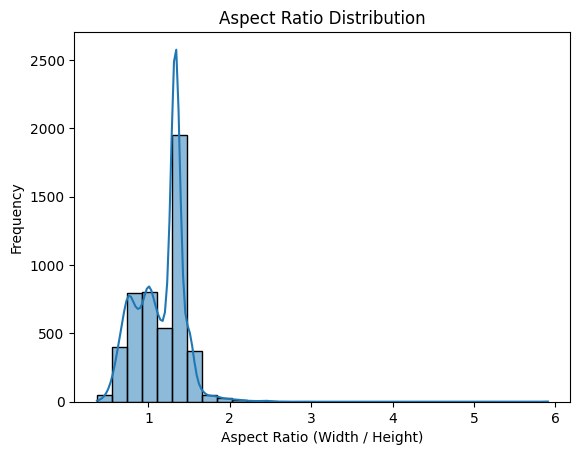

In [20]:
# Add aspect ratio
df_shapes['Aspect_Ratio'] = df_shapes['Width'] / df_shapes['Height']

# Plot distribution of aspect ratios
sns.histplot(df_shapes['Aspect_Ratio'], bins=30, kde=True)
plt.title("Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Frequency")
plt.show()


We calculate the aspect ratio (width divided by height) for each image to understand their shape proportions. 

The plot shows how aspect ratios are distributed across all images, helping identify if most images are close to square or have more varied dimensions.


### 2.5. Check for corrupted images

In [22]:
def check_corrupted_images(directory):
    corrupted = []
    for fname in os.listdir(directory):
        fpath = os.path.join(directory, fname)
        try:
            with Image.open(fpath) as img:
                img.verify()  # verifies integrity
        except (UnidentifiedImageError, IOError, SyntaxError):
            corrupted.append(fname)
    return corrupted

corrupted_cats = check_corrupted_images(CAT_DIR)
corrupted_dogs = check_corrupted_images(DOG_DIR)

print(f"Corrupted cat images: {len(corrupted_cats)}")
print(f"Corrupted dog images: {len(corrupted_dogs)}")

Corrupted cat images: 0
Corrupted dog images: 0


### 2.6. Visual Grid of Random Images

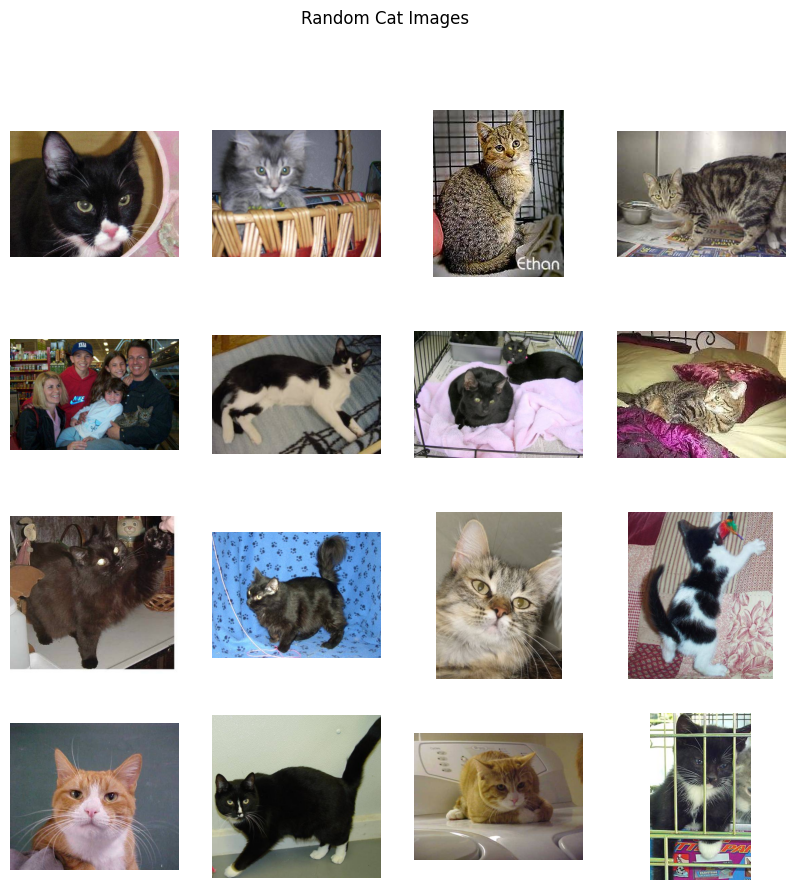

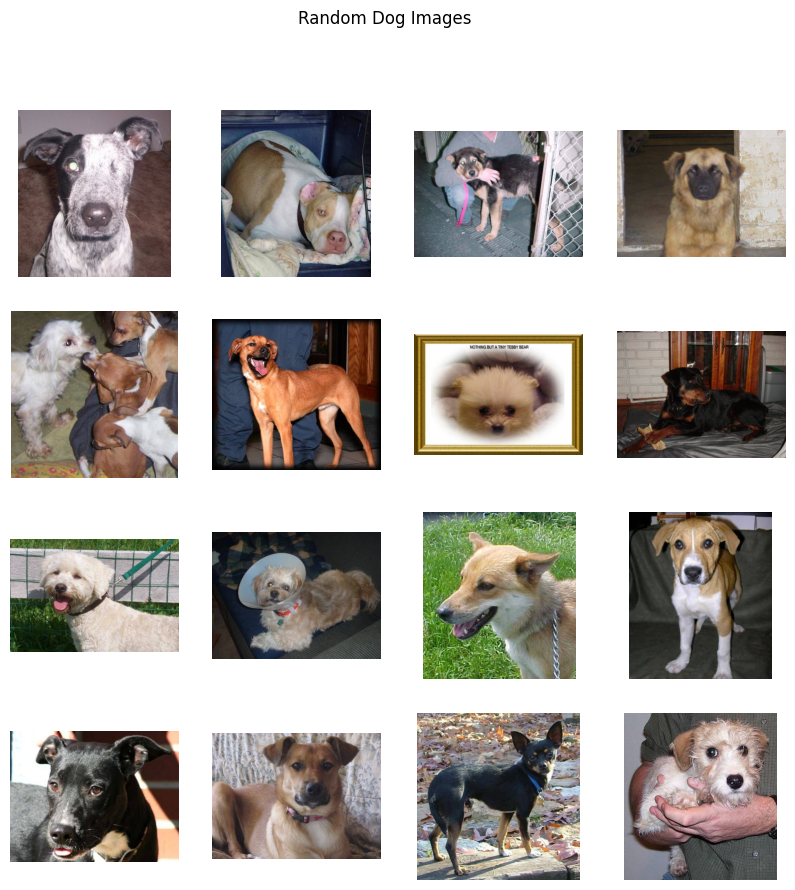

In [23]:
def plot_image_grid(image_dir, title, n=16):
    files = random.sample(os.listdir(image_dir), n)
    plt.figure(figsize=(10, 10))
    for i, file in enumerate(files):
        img = Image.open(os.path.join(image_dir, file))
        plt.subplot(4, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_image_grid(CAT_DIR, "Random Cat Images")
plot_image_grid(DOG_DIR, "Random Dog Images")


In this lab we are going to skip the cleaning step, because in our case with the current dataset it is redundant in time and memory too (mostly in time time of running).

What steps could we take in cleaning? 

### 📋 Cleaning & Preprocessing Summary

Before training our models, we applied several cleaning and preprocessing steps to ensure data quality, reduce noise, and avoid common training issues. The table below summarizes each step, its importance, and whether it has been completed.

| Cleaning Step              | Importance | Done Already?            |
|---------------------------|------------|--------------------------|
| Corrupted file check      | ✅ High     | ✅ Yes                    |
| Remove duplicates         | ✅ Medium   | ✅ Yes, no duplicates          |
| Resize images uniformly   | ⚠️ Low      | ❌ Optional(lose clarity) |
| Rename files consistently | ⚠️ Low      | ❌ Optional(redundant)    |
| Visual inspection         | ✅ Medium   | ⚠️ Suggested              |
| Class balance             | ✅ High     | ✅ Done (2,500 per class) |
| Careful augmentation      | ✅ High     | ✅ Done (only in training) |


## 3. Data Preparation

### 3.1. We'll create a training and validation set with Keras' ImageDataGenerator.

We use `ImageDataGenerator` to scale pixel values and split our dataset into training and validation sets. This step ensures the model generalizes well and helps mitigate overfitting through augmentation.


In [52]:
CAT_DIR = "data/sample_5000/cats"
DOG_DIR = "data/sample_5000/dogs"
BASE_OUT = "data/split"
os.makedirs(BASE_OUT, exist_ok=True)

splits = {
    "train": 1000,
    "val": 500,
    "test": 1000
}

def split_and_copy(src_dir, out_base, splits):
    files = os.listdir(src_dir)
    random.shuffle(files)
    idx = 0
    for split, count in splits.items():
        split_dir = os.path.join(out_base, split, os.path.basename(src_dir))
        os.makedirs(split_dir, exist_ok=True)
        for f in files[idx:idx+count]:
            shutil.copy(os.path.join(src_dir, f), os.path.join(split_dir, f))
        idx += count

split_and_copy(CAT_DIR, BASE_OUT, splits)
split_and_copy(DOG_DIR, BASE_OUT, splits)

print("Split complete. Check data/split/train, data/split/val, data/split/test folders.")

Split complete. Check data/split/train, data/split/val, data/split/test folders.




To handle our images efficiently, we create ImageDataGenerator instances for training and validation sets. This generator will:
- Rescale pixel values to [0,1] range
- Apply data augmentation for training (rotation, zoom, flip)
- Split data into batches
- Create balanced training and validation sets

Key parameters:
- Input image size: 150x150 pixels
- Batch size: 32 images
- Training split: 1000 images/class
- Validation split: 500 images/class
- Test split: 1000 images/class


### 3.2. Defining a custom CNN

Here, we define and train a simple Convolutional Neural Network from scratch. We'll use callbacks to monitor validation loss and save the best performing model.


In [53]:
# Updated directories after split
TRAIN_DIR = "data/split/train"
VAL_DIR = "data/split/val"

IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow from updated directories
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Define custom CNN model
def create_custom_cnn(input_shape=(150, 150, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Compile and train the model
cnn_model = create_custom_cnn()
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_checkpoint = callbacks.ModelCheckpoint("cnn_best_model.h5", save_best_only=True, monitor='val_loss', mode='min')
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

cnn_history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[cnn_checkpoint, early_stop]
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


c:\Users\User\miniconda3\envs\ml-env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\User\miniconda3\envs\ml-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.5542 - loss: 0.9740

63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 990ms/step - accuracy: 0.5538 - loss: 0.9709 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 538ms/step - accuracy: 0.5038 - loss: 0.6899 - val_accuracy: 0.5360 - val_loss: 0.6951
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.5724 - loss: 0.6772

63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 598ms/step - accuracy: 0.5725 - loss: 0.6771 - val_accuracy: 0.6140 - val_loss: 0.6600
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 495ms/step - accuracy: 0.6223 - loss: 0.6476 - val_accuracy: 0.5560 - val_loss: 0.6748
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.6027 - loss: 0.6528

63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 573ms/step - accuracy: 0.6032 - loss: 0.6526 - val_accuracy: 0.6610 - val_loss: 0.6144
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 529ms/step - accuracy: 0.6437 - loss: 0.6201 - val_accuracy: 0.6690 - val_loss: 0.6259
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.6877 - loss: 0.6029

63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 532ms/step - accuracy: 0.6877 - loss: 0.6028 - val_accuracy: 0.6700 - val_loss: 0.5925
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.6741 - loss: 0.5826

63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 572ms/step - accuracy: 0.6743 - loss: 0.5826 - val_accuracy: 0.6770 - val_loss: 0.5912
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 561ms/step - accuracy: 0.7106 - loss: 0.5618 - val_accuracy: 0.6860 - val_loss: 0.6010
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.7480 - loss: 0.5206

63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 565ms/step - accuracy: 0.7479 - loss: 0.5207 - val_accuracy: 0.7290 - val_loss: 0.5396
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 554ms/step - accuracy: 0.7510 - loss: 0.5133 - val_accuracy: 0.6890 - val_loss: 0.5793
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.7409 - loss: 0.5227

63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 526ms/step - accuracy: 0.7408 - loss: 0.5229 - val_accuracy: 0.7470 - val_loss: 0.5206
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 550ms/step - accuracy: 0.7368 - loss: 0.4957 - val_accuracy: 0.7410 - val_loss: 0.5219
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 540ms/step - accuracy: 0.7680 - loss: 0.4671 - val_accuracy: 0.7340 - val_loss: 0.5216
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.7903 - loss: 0.4333

63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 520ms/step - accuracy: 0.7902 - loss: 0.4334 - val_accuracy: 0.7570 - val_loss: 0.5130
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 530ms/step - accuracy: 0.8027 - loss: 0.4250 - val_accuracy: 0.7160 - val_loss: 0.6345
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 542ms/step - accuracy: 0.7878 - loss: 0.4371 - val_accuracy: 0.7420 - val_loss: 0.5234
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.8001 - loss: 0.4153

63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 526ms/step - accuracy: 0.8003 - loss: 0.4149 - val_accuracy: 0.7740 - val_loss: 0.4831
Epoch 19/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 571ms/step - accuracy: 0.8206 - loss: 0.4030 - val_accuracy: 0.7530 - val_loss: 0.6172
Epoch 20/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 552ms/step - accuracy: 0.8181 - loss: 0.4104 - val_accuracy: 0.7800 - val_loss: 0.4944


We build a simple Convolutional Neural Network with three convolutional layers followed by dense layers to classify cat and dog images.

The model uses Adam optimizer and binary cross-entropy loss. We include callbacks to save the best model and stop early if validation loss stops improving to prevent overfitting.


### 3.3. Fine-tuning VGG16



We fine-tune the VGG16 architecture pre-trained on ImageNet. We freeze the convolutional base and only train the top layers to adapt to the Cats vs. Dogs classification task.


In [57]:
# Updated directories after manual split
TRAIN_DIR = "data/split/train"
VAL_DIR = "data/split/val"

IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Data generators note: no validation_split here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Load VGG16 base and freeze it
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg_base.trainable = False

# Add custom classification head
vgg_model = models.Sequential([
    vgg_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile and train
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

vgg_checkpoint = callbacks.ModelCheckpoint("vgg16_best_model.h5", save_best_only=True, monitor='val_loss', mode='min')
early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

vgg_history = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[vgg_checkpoint, early_stop]
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7012 - loss: 0.6739

63/63 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.7022 - loss: 0.6714 - val_accuracy: 0.8600 - val_loss: 0.3269
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8557 - loss: 0.3384

63/63 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.8555 - loss: 0.3386 - val_accuracy: 0.8720 - val_loss: 0.2888
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.8711 - loss: 0.2975 - val_accuracy: 0.8590 - val_loss: 0.3081
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8766 - loss: 0.2805

63/63 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.8766 - loss: 0.2806 - val_accuracy: 0.8820 - val_loss: 0.2765
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.8796 - loss: 0.2713 - val_accuracy: 0.8620 - val_loss: 0.3133
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8937 - loss: 0.2422

63/63 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.8937 - loss: 0.2424 - val_accuracy: 0.8820 - val_loss: 0.2556
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.9051 - loss: 0.2332 - val_accuracy: 0.8860 - val_loss: 0.2655
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9038 - loss: 0.2177

63/63 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.9037 - loss: 0.2178 - val_accuracy: 0.8850 - val_loss: 0.2510
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.9030 - loss: 0.2298 - val_accuracy: 0.8910 - val_loss: 0.2557
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.9172 - loss: 0.1938 - val_accuracy: 0.8840 - val_loss: 0.2564
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.9166 - loss: 0.1975 - val_accuracy: 0.8950 - val_loss: 0.2561
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.9407 - loss: 0.1678 - val_accuracy: 0.8840 - val_loss: 0.2751
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.9123 - loss: 0.2103 - val_accuracy: 0.8800 - val_loss: 0.2608
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.9278 - loss: 0.1851 - val_accuracy: 0.8920 - val_loss: 0.2672
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.9260 - loss: 0.1698 - val_accuracy: 0.8900 - val_lo


We use a pre-trained VGG16 model as a fixed feature extractor by freezing its weights, then add a custom classification head on top.

This approach leverages learned image features from ImageNet and fine-tunes only the new layers for our binary cat vs. dog classification task.


### Training vs Validation Accuracy and Loss

To evaluate if overfitting occurred, we plot training and validation accuracy/loss for both the custom CNN and VGG16 models. A large gap between training and validation metrics can indicate overfitting.


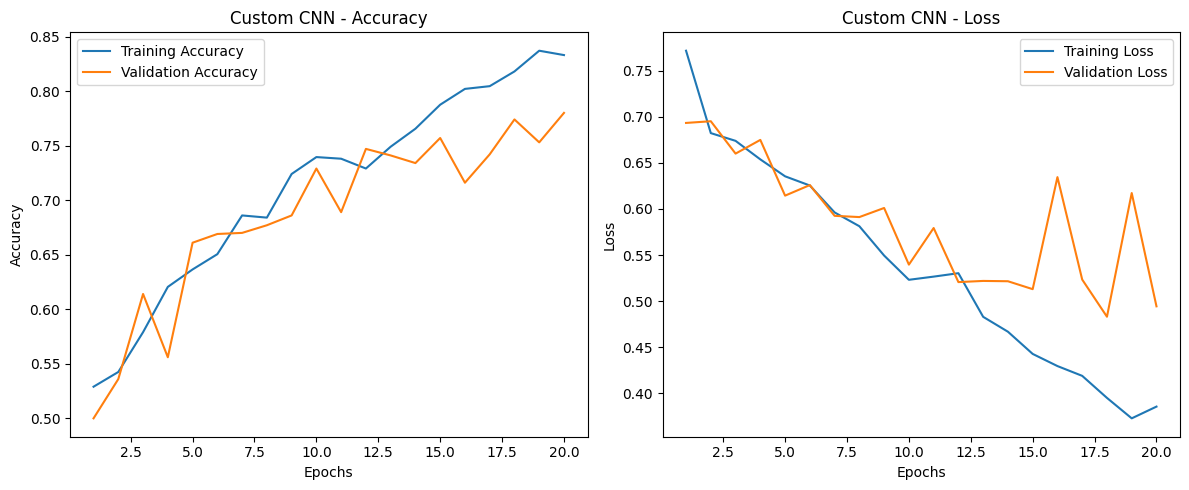

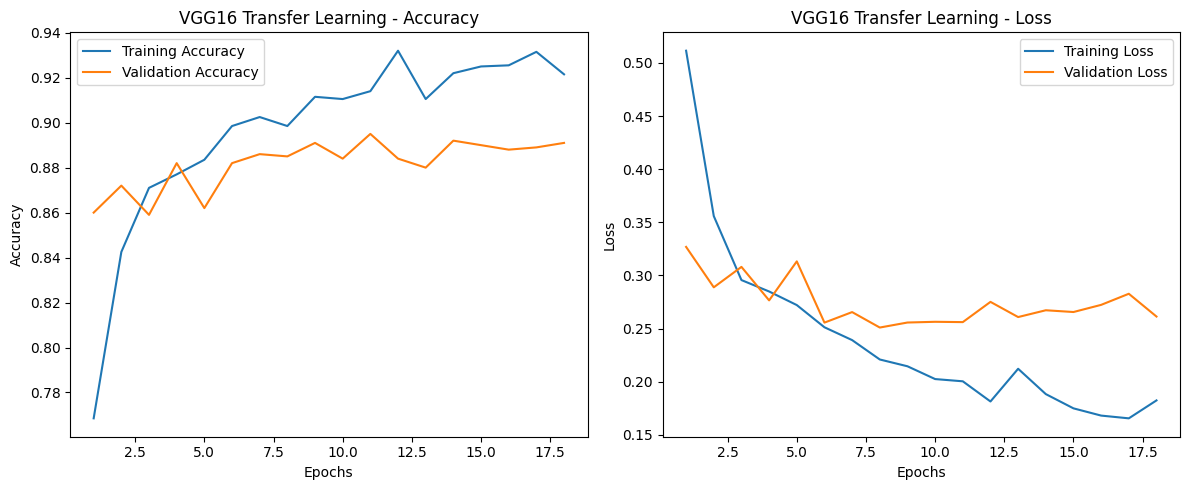

In [58]:
def plot_training_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for both models
plot_training_history(cnn_history, "Custom CNN")
plot_training_history(vgg_history, "VGG16 Transfer Learning")


This function plots training and validation accuracy and loss over epochs for any given model.

It helps us compare how well our Custom CNN and VGG16 models learned and generalized during training.


## 4. Comparing the models

### 4.1. Loading the best models

In [59]:
custom_model = load_model('cnn_best_model.h5')
vgg_model = load_model('vgg16_best_model.h5')

### 4.2. Preparing the test data

In [61]:
# Updated test directory
TEST_DIR = "data/split/test"
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# ImageDataGenerator for test set
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 2000 images belonging to 2 classes.



We organize test images by reading filenames and assigning class labels based on the filename prefix. 

Using an `ImageDataGenerator`, we preprocess and load the test set without shuffling, preparing it for evaluation.


### 4.3. Evaluation Metrics (Confusion Matrix, Classification Report)

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step

Evaluation for Custom CNN
              precision    recall  f1-score   support

         Cat       0.78      0.75      0.77      1000
         Dog       0.76      0.79      0.77      1000

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000



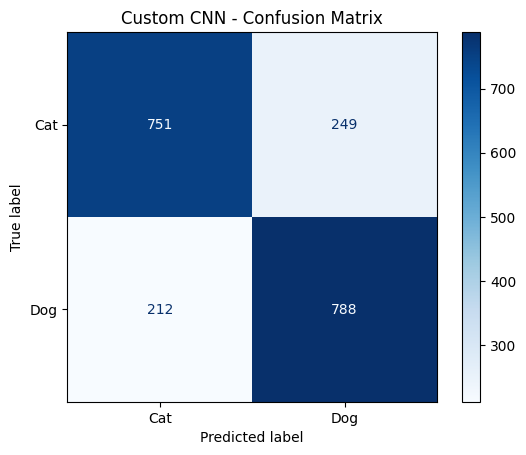

63/63 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step

Evaluation for VGG16
              precision    recall  f1-score   support

         Cat       0.91      0.89      0.90      1000
         Dog       0.89      0.91      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



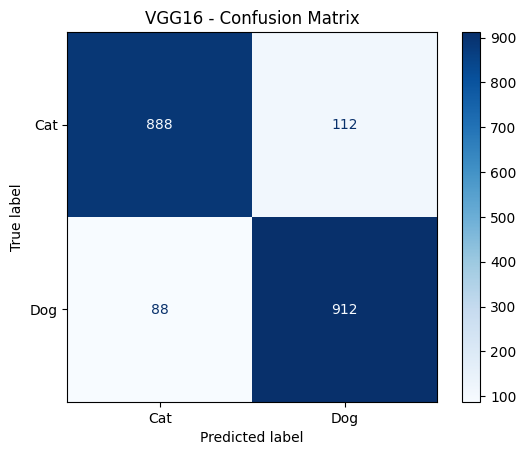

In [63]:
def evaluate_model(model, generator, model_name="Model"):
    y_true = generator.classes
    y_pred_probs = model.predict(generator)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()
    
    print(f"\nEvaluation for {model_name}")
    print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()
    
    return y_true, y_pred, y_pred_probs

# Evaluate both models on the test set
y_true_cnn, y_pred_cnn, y_probs_cnn = evaluate_model(cnn_model, test_generator, "Custom CNN")
y_true_vgg, y_pred_vgg, y_probs_vgg = evaluate_model(vgg_model, test_generator, "VGG16")

This function evaluates a model by generating predictions on the test data, printing classification metrics, and plotting the confusion matrix.

We apply it to both the Custom CNN and VGG16 models to compare their performance on unseen images.


### 4.4. precision, recall, F1-score table

In [66]:
def get_metrics_df(y_true, y_pred, model_name):
    # Get classification report as dictionary
    report_dict = classification_report(
        y_true, y_pred,
        output_dict=True,
        target_names=['Cat', 'Dog']
    )
    
    # Extract only class-specific metrics
    metrics_df = pd.DataFrame(report_dict).T.loc[["Cat", "Dog"]]
    
    # Add model name
    metrics_df["Model"] = model_name
    
    return metrics_df[["Model", "precision", "recall", "f1-score"]]

# Get metrics for both models
df_cnn = get_metrics_df(y_true_cnn, y_pred_cnn, "Custom CNN")
df_vgg = get_metrics_df(y_true_vgg, y_pred_vgg, "VGG16")

# Combine into one table
results_table = pd.concat([df_cnn, df_vgg], axis=0).reset_index().rename(columns={'index': 'Class'})

# Show the table
print("Evaluation Metrics Table")
display(results_table)

Evaluation Metrics Table


Class       Model  precision  recall  f1-score
0   Cat  Custom CNN   0.779855   0.751  0.765155
1   Dog  Custom CNN   0.759884   0.788  0.773687
2   Cat       VGG16   0.909836   0.888  0.898785
3   Dog       VGG16   0.890625   0.912  0.901186



We extract key classification metrics (precision, recall, F1-score) for each class from both models, then combine them into a single table.

This lets us easily compare how the Custom CNN and VGG16 perform on cats and dogs.


### 4.5. Precision - Recall Curve

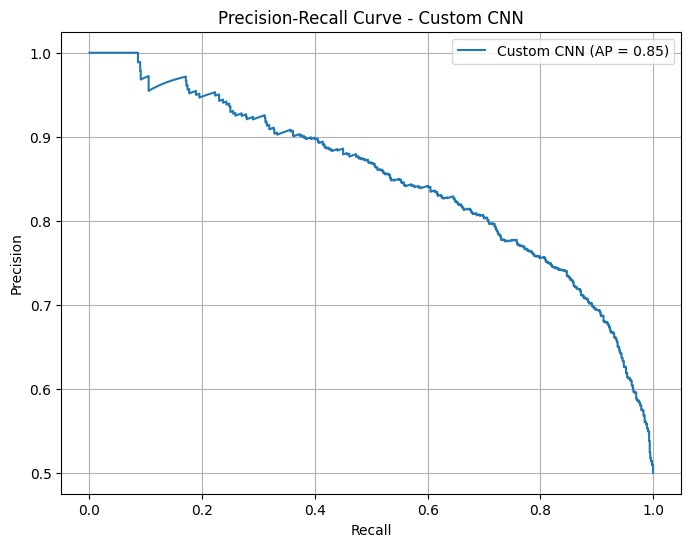

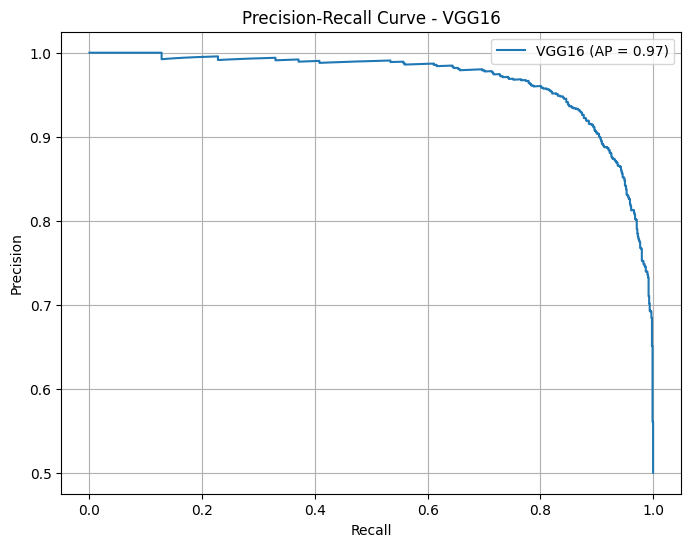

In [67]:
def plot_pr_curve(y_true, y_probs, model_name="Model"):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    avg_precision = average_precision_score(y_true, y_probs)

    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend()
    plt.grid()
    plt.show()

# Plot for both models (evaluated on test set)
plot_pr_curve(y_true_cnn, y_probs_cnn, "Custom CNN")
plot_pr_curve(y_true_vgg, y_probs_vgg, "VGG16")



This plot shows the trade-off between precision and recall for each model across different thresholds, with the Average Precision (AP) score summarizing overall performance.

It helps evaluate how well the models balance false positives and false negatives, especially important in imbalanced datasets.


### 4.6. Misclassified Images Visualization


Misclassified Images from Custom CNN


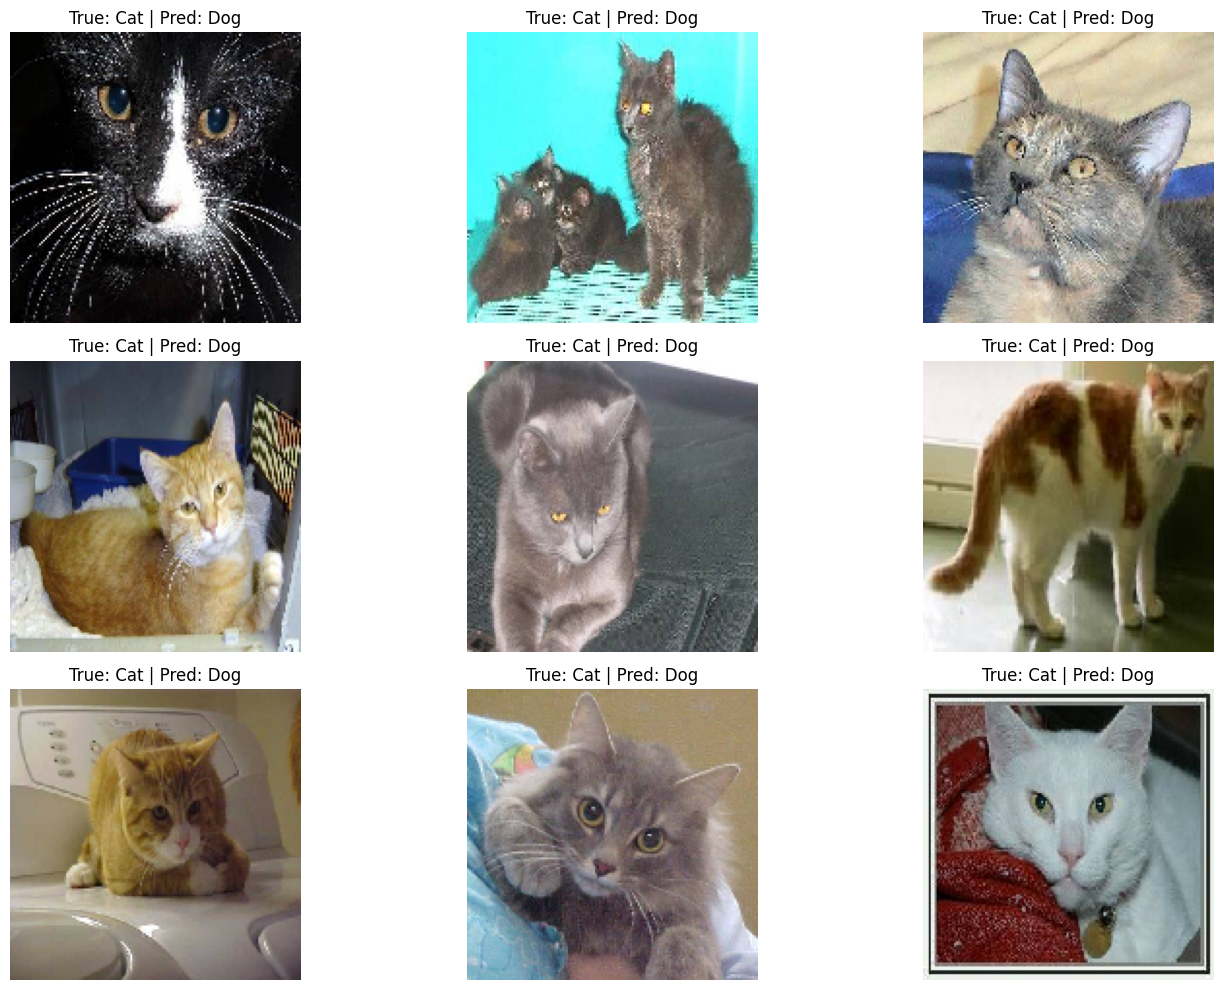


Misclassified Images from VGG16


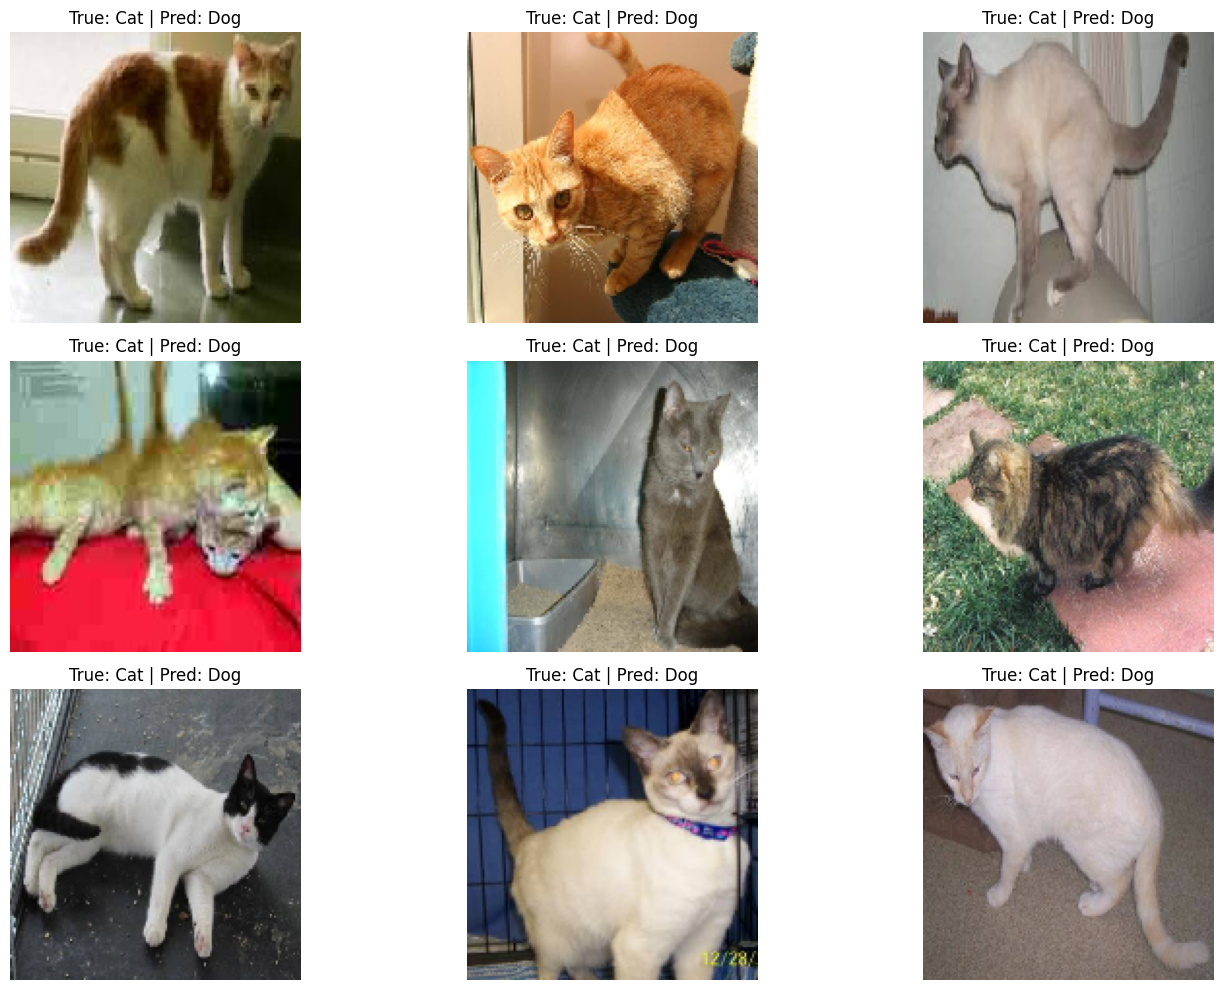

In [68]:
def show_misclassified_images(generator, y_true, y_pred, model_name="Model"):
    print(f"\nMisclassified Images from {model_name}")
    misclassified_indices = np.where(y_true != y_pred)[0]
    filenames = np.array(generator.filepaths)[misclassified_indices]

    plt.figure(figsize=(15,10))
    for i, filepath in enumerate(filenames[:9]):  # show up to 9
        img = image.load_img(filepath, target_size=(150, 150))
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        true_label = 'Dog' if y_true[misclassified_indices[i]] else 'Cat'
        pred_label = 'Dog' if y_pred[misclassified_indices[i]] else 'Cat'
        plt.title(f"True: {true_label} | Pred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display misclassified images for both models (on test set)
show_misclassified_images(test_generator, y_true_cnn, y_pred_cnn, "Custom CNN")
show_misclassified_images(test_generator, y_true_vgg, y_pred_vgg, "VGG16")

This section displays a sample of images that each model misclassified, showing the true and predicted labels.

Examining these examples helps us understand common mistakes and potential challenges in the dataset.


## Conclusion: Model Comparison and Analysis

We evaluated two models on a balanced test dataset of **2,000 images** (1,000 cats and 1,000 dogs): a **Custom CNN** and a **fine-tuned VGG16**. The results table shows that **VGG16 still outperformed the custom model** in every single aspect.

### Performance Summary

| Metric           | Custom CNN | VGG16     |
|------------------|------------|-----------|
| Accuracy         | 77%        | **90%**   |
| F1-score (Cat)   | 0.77       | **0.90**  |
| F1-score (Dog)   | 0.77       | **0.90**  |
| Recall (Cat)     | 0.75       | **0.89**  |
| Recall (Dog)     | 0.79       | **0.91**  |
| Precision (Cat)  | 0.78       | **0.91**  |
| Precision (Dog)  | 0.76       | **0.89**  |

### Why VGG16 Still Performed Better:
- **Transfer Learning**: The pre-trained VGG16 can extract highly discriminative features due to its training on millions of images from ImageNet.
- **Consistency Across Classes**: VGG16 maintained balanced performance across both cats and dogs, with nearly identical F1-scores.
- **Deeper Representations**: Its deeper convolutional layers help recognize subtle patterns (e.g., fur, ears, snouts) that the custom CNN might miss.

### Why the Custom CNN Improved, But Lagged:
- **Better Than Expected**: With an accuracy of **77%**, the custom CNN performed reasonably well on the balanced test set.
- **Still Shallow**: Its limited architecture may not extract deep visual cues as effectively.
- **Small Margin Errors**: Slightly lower precision and recall for both classes indicate it still struggles with fine-grained distinctions.

## Conclusion / Observation

This comparison highlights the **importance of model architecture, depth, and transfer learning** in solving real-world image classification problems.

We evaluated a Custom CNN and a fine-tuned VGG16 model on a balanced test set of 2,000 images (1,000 cats and 1,000 dogs). The Custom CNN achieved a solid 77% accuracy, while VGG16 outperformed it with a 90% accuracy, along with stronger precision, recall, and F1-scores for both classes.

The Custom CNN* while impressive for a from-scratch model, lacked the capacity to extract high-level features as effectively as VGG16. On the other hand, VGG16 leveraged transfer learning from ImageNet, enabling it to generalize better and maintain consistent performance across both classes.

> **Observation**: The custom model struggled slightly more with misclassifying borderline examples, likely due to its shallower depth and limited feature expressiveness.

> **Conclusion**: In environments involving complex visual features and high-performance demands, **pre-trained deep learning architectures like VGG16 offer superior scalability, robustness, and classification accuracy** compared to custom-built shallow CNNs.
